In [1]:

import os
import shutil
import time
from collections import defaultdict


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from SALib.analyze import sobol


from ema_workbench import (
    Model, Policy, Scenario, MultiprocessingEvaluator,
    ema_logging
)
from ema_workbench.analysis import (
    feature_scoring, parcoords, pairs_plotting, prim
)
from ema_workbench.em_framework.evaluators import (
    BaseEvaluator, perform_experiments
)
from ema_workbench.em_framework.optimization import (
    ArchiveLogger, EpsilonProgress, EpsNSGAII,
    HyperVolume, epsilon_nondominated, to_problem
)
from ema_workbench.em_framework.outcomes import ScalarOutcome
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.samplers import sample_uncertainties


from problem_formulation import get_model_for_problem_formulation
from ema_workbench.analysis import dimensional_stacking
from pandas.api.types import is_numeric_dtype, is_categorical_dtype




## Running and showing the model

In [ ]:
if __name__ == "__main__":

    # --- Load your model ---
    model, planning_steps = get_model_for_problem_formulation(3)



    reference_values = {
        "Bmax": 175,
        "Brate": 1.5,
        "pfail": 0.5,
        "discount rate 0": 3.5,
        "discount rate 1": 3.5,
        "discount rate 2": 3.5,
        "ID flood wave shape": 4,
    }
    scen1 = {}

    for key in model.uncertainties:
        name_split = key.name.split("_")

        if len(name_split) == 1:
            scen1.update({key.name: reference_values[key.name]})

        else:
            scen1.update({key.name: reference_values[name_split[1]]})

    ref_scenario = Scenario("reference", **scen1)


    convergence_metrics = [

    EpsilonProgress(),
]

    espilon = [0.01] * len(model.outcomes)


    nfe = 100000 # proof of principle only, way to low for actual use

    with MultiprocessingEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(
            nfe=nfe,
            searchover="levers",
            epsilons=espilon,
            convergence=convergence_metrics,
            reference=ref_scenario,
        )

INFO | pool started with 8 workers
  3%|▉                                 | 2789/100000 [10:15<3:24:52,  7.91it/s]

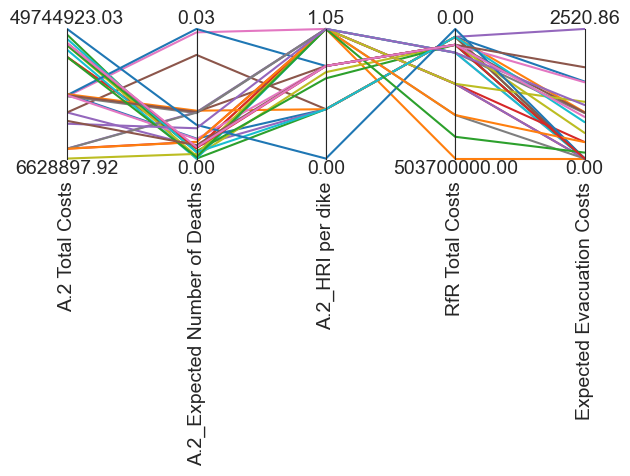

<Figure size 1400x1000 with 0 Axes>

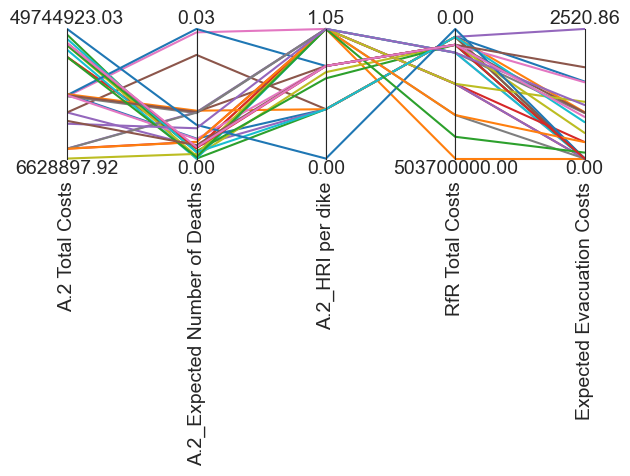

In [14]:
data = results.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis("RfR Total Costs")
    # Set larger figure size (wider and taller)
plt.figure(figsize=(14, 10))  # width=12 inches, height=8 inches

# Generate parallel axes with your limits
paraxes = parcoords.ParallelAxes(limits)

# Plot the data
paraxes.plot(data)

# Invert specific axis
paraxes.invert_axis("RfR Total Costs")

# Save the plot
plt.savefig("mordm_parallel_coordinates.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [15]:
print(results)

    0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
0         0        0        0        0        0        0        1        0   
1         1        1        0        0        0        0        1        1   
2         0        0        0        0        0        0        1        0   
3         0        0        0        0        0        0        1        1   
4         0        0        0        0        0        0        1        0   
5         0        0        0        0        0        0        1        0   
6         0        0        0        0        0        0        1        1   
7         0        0        0        0        0        0        1        1   
8         0        0        0        0        0        0        1        0   
9         0        0        0        0        0        0        1        1   
10        0        0        0        0        0        0        1        1   
11        0        0        0        0        0        0        

## optimized policies

In [16]:
policies = results
policies = policies.drop([o.name for o in model.outcomes], axis=1)
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,0,0,0,0,0,0,1,0,0,0,...,0,6,2,0,7,3,3,4,5,7
1,1,1,0,0,0,0,1,1,1,0,...,0,0,5,1,4,5,2,6,6,0
2,0,0,0,0,0,0,1,0,0,0,...,0,7,2,0,3,2,5,7,4,5
3,0,0,0,0,0,0,1,1,1,0,...,0,5,5,0,1,4,2,2,2,7
4,0,0,0,0,0,0,1,0,0,0,...,0,3,5,6,2,4,0,5,5,6
5,0,0,0,0,0,0,1,0,0,0,...,0,1,2,6,2,3,2,5,3,6
6,0,0,0,0,0,0,1,1,1,0,...,0,2,3,2,5,3,1,1,5,7
7,0,0,0,0,0,0,1,1,1,0,...,0,3,5,1,7,1,6,6,5,7
8,0,0,0,0,0,0,1,0,1,0,...,0,0,5,0,7,1,1,7,4,6
9,0,0,0,0,0,0,1,1,1,0,...,0,7,2,1,2,4,2,7,3,4


In [17]:
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [18]:
#Create policy dataframe
lever_names = [l.name for l in model.levers]
policies_df = results[lever_names]
policies_df.to_csv("candidate_policies.csv", index=False)

## Testing out the policies

In [19]:
n_scenarios = 100
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

python(53258) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53263) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53264) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53265) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53272) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53275) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53276) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(53277) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 100 scenarios * 27 policies * 1 model(s) = 2700 experiments
100%|██████████████████████████████████████| 2700/2700 [03:13<00:00, 13.95it/s]

In [20]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    if std==0:
        std = 1

    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std


In [21]:
experiments, outcomes = results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy']==policy

    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.2 Total Costs,A.2_Expected Number of Deaths,A.2_HRI per dike,RfR Total Costs,Expected Evacuation Costs
0,4.049861e+16,0.000735,-0.408248,30700000.0,1.056451e+08
1,1.002422e+16,0.004128,1.801045,503700000.0,0.000000e+00
10,2.527640e+16,0.019614,0.480096,61400000.0,0.000000e+00
11,4.049861e+16,0.004236,-0.408248,30700000.0,4.042458e+07
12,7.286520e+15,0.002519,0.923760,61400000.0,0.000000e+00
13,1.505063e+16,0.001483,1.326807,213300000.0,2.384136e+07
14,1.358779e+16,0.010374,1.326807,213300000.0,0.000000e+00
15,2.571989e+16,0.002605,0.480096,61400000.0,2.675490e+07
16,2.534529e+16,0.000444,0.480096,61400000.0,8.092540e+07
17,1.144362e+16,0.008579,1.437500,334500000.0,0.000000e+00


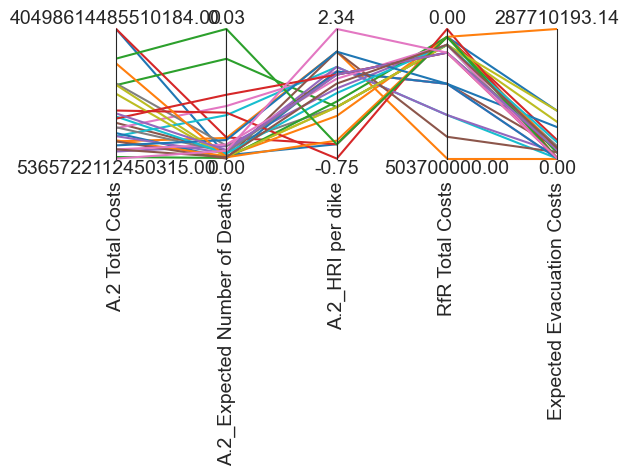

In [22]:
data = scores
limits = parcoords.get_limits(data)


paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis("RfR Total Costs")

plt.show()

In [23]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [24]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']

    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name],
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})

    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')

    # flatten the resulting hierarchical index resulting from
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)

    # we need to control the broadcasting.
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

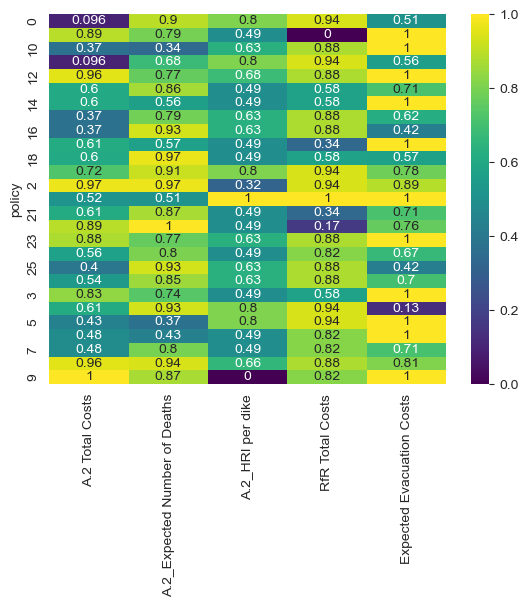

In [25]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

In [26]:

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

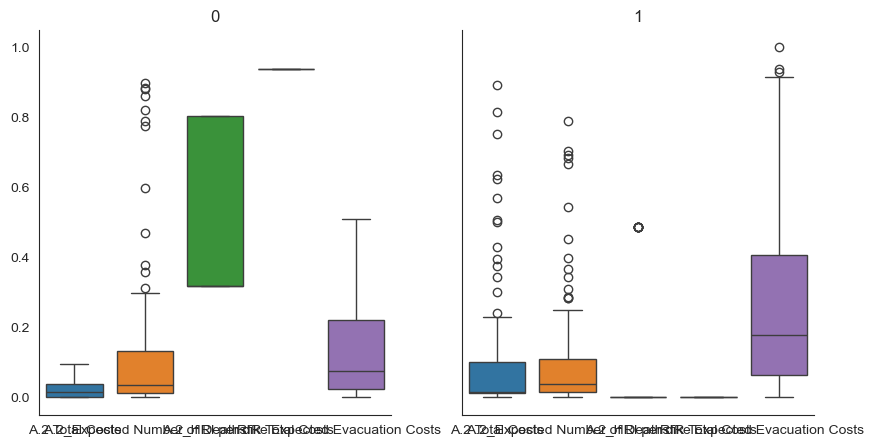

In [27]:
# this generates a 2 plots with a shared y and x axis
fig, axes = plt.subplots(ncols=2, figsize=(10,5),
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this.


# zip allows us to zip together the list of axes and the list of
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)

    # removes top and left hand black outline of axes
    sns.despine()

    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
plt.show()

## Selecteren scenarios maar gaan we doen met PRIM

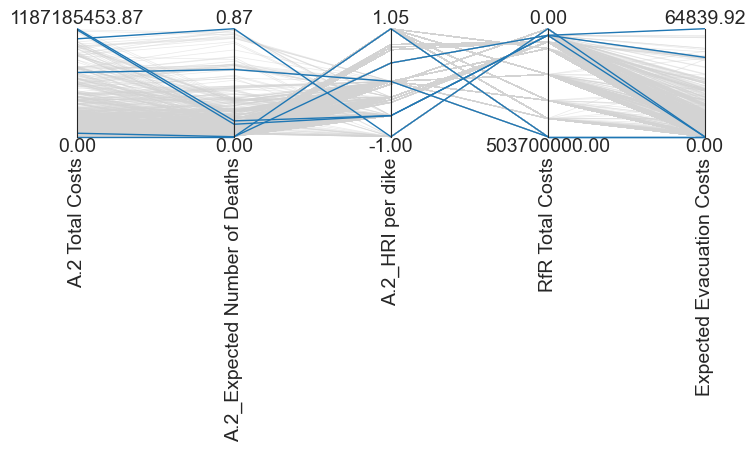

In [28]:
all_data = pd.DataFrame({k:v for k,v in outcomes.items()})

# let's get the unique indices for the minima and maxima across
# all objectives
indices = pd.concat([all_data.idxmax(), all_data.idxmin()]).unique()

limits = parcoords.get_limits(all_data)
axes = parcoords.ParallelAxes(limits)

# we set the linewidth lower, and make the lines slightly transpartant using alpha
# this often helps reveal patterns in the results.
axes.plot(all_data, color='lightgrey', lw=0.5, alpha=0.5)
axes.plot(all_data.iloc[indices, :], color=sns.color_palette()[0], lw=1)
axes.invert_axis('RfR Total Costs')

fig = plt.gcf()
fig.set_size_inches((8, 4))

plt.show()

In [29]:
print(all_data.idxmax())
print(all_data.idxmin())

A.2 Total Costs                    83
A.2_Expected Number of Deaths    2000
A.2_HRI per dike                  102
RfR Total Costs                   100
Expected Evacuation Costs         483
dtype: int64
A.2 Total Costs                     9
A.2_Expected Number of Deaths       9
A.2_HRI per dike                 2000
RfR Total Costs                  2000
Expected Evacuation Costs           9
dtype: int64


In [30]:
selected = experiments.loc[[10, 1]]
selected

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
10,24,222.083267,1.0,0.423658,225.529040,1.5,0.639265,317.950697,1.5,0.804867,...,0,7,3,3,4,5,7,10,0,dikesnet
1,14,155.219636,1.0,0.107747,308.579297,10.0,0.208317,260.221159,10.0,0.075544,...,0,7,3,3,4,5,7,1,0,dikesnet


In [44]:
policies_df = pd.read_csv("candidate_policies.csv")

# zet elke rij om in een Policy-object
candidate_policies = [
    Policy(f"cand_{i}", **row.to_dict())
    for i, row in policies_df.iterrows()

    ]

In [45]:
if __name__ == "__main__":
    model, _ = get_model_for_problem_formulation(3)
    scenarios=10000
    policies=4
    with MultiprocessingEvaluator(model, n_processes=-1) as evaluator:
        results = evaluator.perform_experiments(scenarios=scenarios, policies=candidate_policies )

        experiments, outcomes = results

python(54073) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54083) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54084) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54085) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54086) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54087) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54088) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
[MainProcess/INFO] pool started with 7 workers
[MainProcess/INFO] performing 10 scenarios * 27 policies * 1 model(s) = 270 experiments
100%|████████████████████████████████████████| 270/270 [00:12<00:00, 21.86it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [46]:
hri_sys = outcomes["A.2_HRI per dike"]
hri_q25 = np.percentile(hri_sys, 25)# (N,) systeembreed
target_hri = hri_sys <= hri_q25

        # ---- 2.2 Expected Annual Damage ----
ead_total = outcomes["A.2 Total Costs"] # (N,)
ead_q75 = np.percentile(ead_total, 75)
target_ead = ead_total >= ead_q75

        # # ---- 2.3 RfR Total Costs ----
        # rfr_costs = outcomes["RfR Total Costs"].sum(axis=1)  # (N,)
        # rfr_q75 = np.percentile(rfr_costs, 75)
        # target_rfr = rfr_costs >= rfr_q75

        # ---- 2.4 Combineer tot één worst-case target ----
y = target_hri | target_ead        # booleaanse vector (N,)
print(f"worst-cases: {y.sum()} van {n_scenarios*policies} runs  ({y.mean()*100:.1f} %)")

        #Determine model uncertainties
cols_unc = [u.name for u in model.uncertainties]
X = experiments[cols_unc]

#Start PRIM
prim_alg = prim.Prim(
            X, y,
            threshold=0.80,
        )

print("Aantal opgeslagen boxen:", len(prim_alg.boxes))

worst-cases: 98 van 400 runs  (36.3 %)
Aantal opgeslagen boxen: 1


[MainProcess/INFO] 2700 points remaining, containing 958 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.13, coverage: 0.3663883089770355, density: 1.0 restricted_dimensions: 4


coverage      0.366388
density       1.000000
id           31.000000
k           351.000000
mass          0.130000
mean          1.000000
n           351.000000
res_dim       4.000000
Name: 31, dtype: float64

                          box 31                                         
                             min              max qp value       qp value
A.2_pfail               0.002656          0.18179      NaN  1.454328e-139
A.4_Bmax               31.490269       302.174072      NaN   1.553502e-01
A.1_Bmax               71.099104       346.837357  0.15535            NaN
discount rate 1  {1.5, 2.5, 4.5}  {1.5, 2.5, 4.5}  0.41990            NaN



/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{1.5, 2.5, 4.5}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]


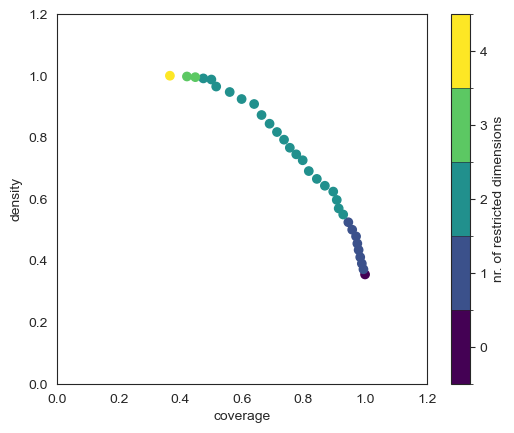

32 stappen in deze box


In [39]:
# A) De “beste” box volgens je threshold
box = prim_alg.find_box()
box.inspect()
box.show_tradeoff()
plt.show()# geeft een PrimBox terug
traj = box.peeling_trajectory
print(len(traj), "stappen in deze box")

[<Figure size 640x480 with 1 Axes>]

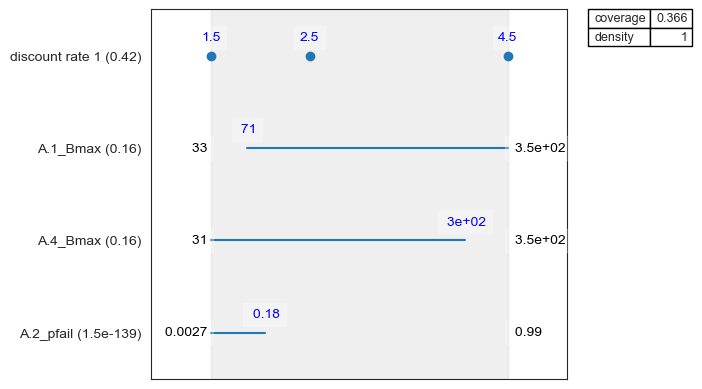

In [47]:
# en inspecteer 'm meteen
box.inspect( style="graph" )

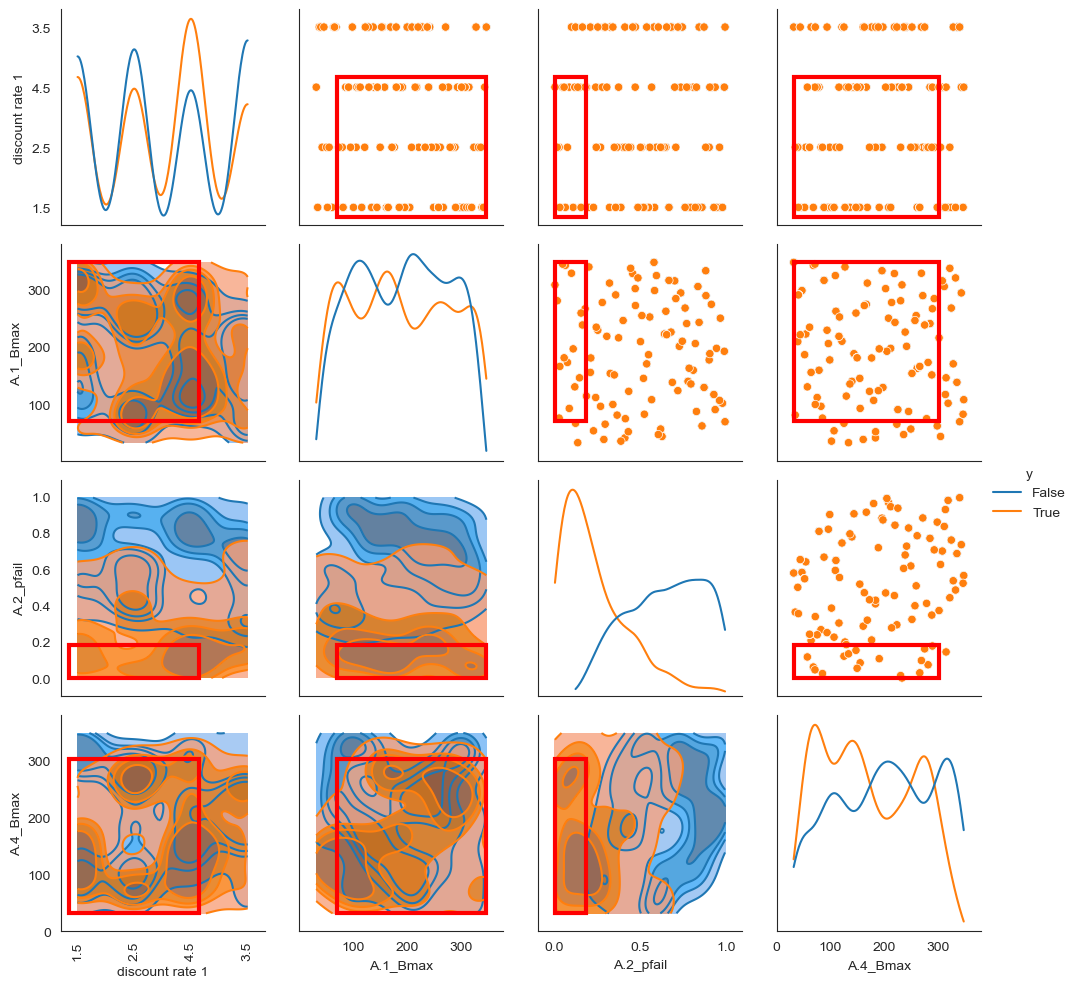

In [48]:
fig = box.show_pairs_scatter()
plt.show()

[MainProcess/INFO] model dropped from analysis because only a single category


origineel aantal kolommen: 53
zonder levers           : 22


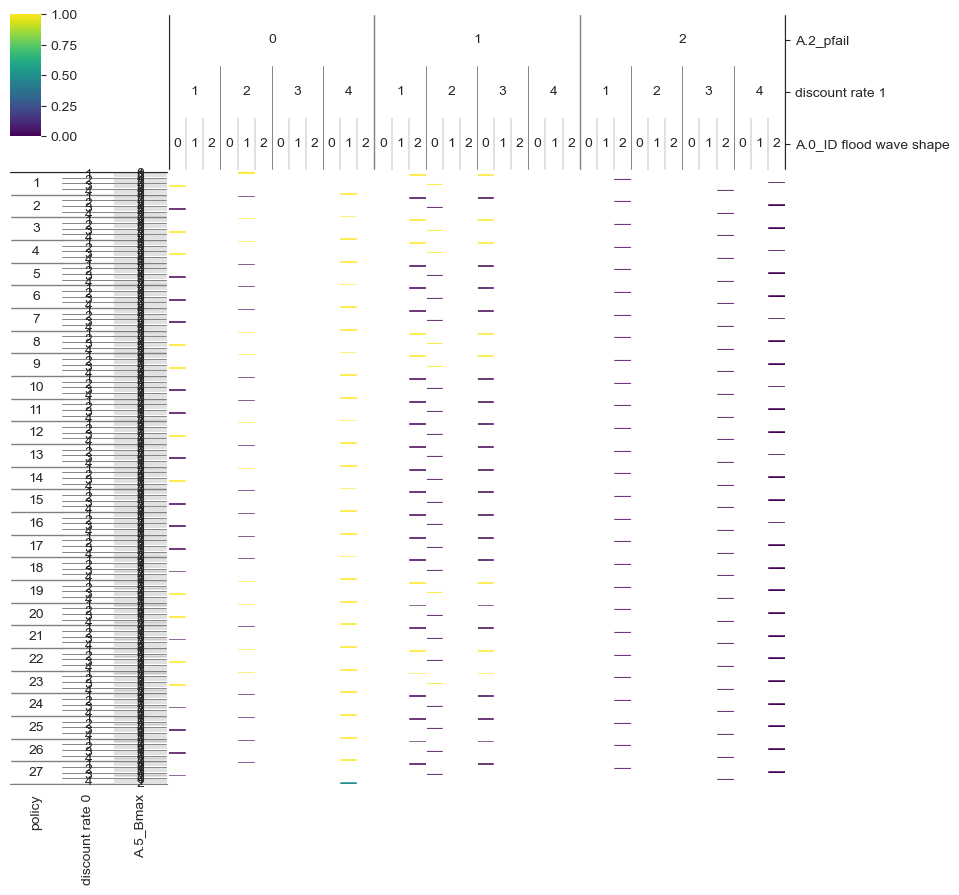

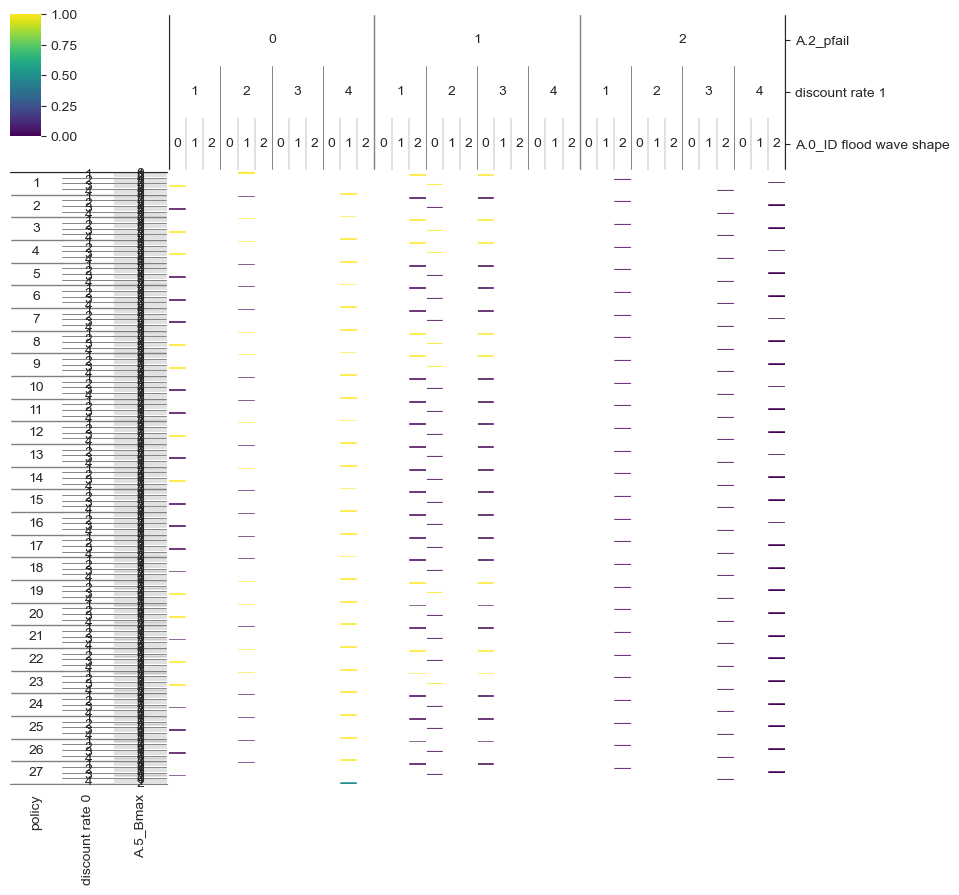

In [49]:
lever_names = [lev.name for lev in model.levers]
experiments_unc = experiments.drop(columns=lever_names)


# even checken:
print("origineel aantal kolommen:", experiments.shape[1])
print("zonder levers           :", experiments_unc.shape[1])

dimensional_stacking.create_pivot_plot(experiments_unc, y)


In [75]:

# 1) Haal de grenzen op uit de box (list met één entry per box in je peeling_trajectory)
raw_limits = box.box_lims[0]

# 1) Transponeren, zodat elke var een rij wordt, en de kolommen 0 en 1 zijn
df_lim = raw_limits.T

# 2) Hernoemen van de kolommen 0→min en 1→max
df_lim = df_lim.rename(columns={0: "min", 1: "max"})

# 3) (optioneel) zet de index-naam netjes
df_lim.index.name = "var"

In [76]:
df_lim
mask = pd.Series(True, index=experiments.index)

for var, row in df_lim.iterrows():
    lo, hi = row["min"], row["max"]
    ser = experiments[var]

    if is_numeric_dtype(ser):
        # voor numerieke parameters
        mask &= ser.between(lo, hi)
    else:
        # voor categorische parameters
        # lo kan een set/list zijn, of een enkele waarde
        if isinstance(lo, (set, list)):
            mask &= ser.isin(lo)
        else:
            mask &= (ser == lo)

exp_in_box = experiments[mask]
out_in_box = {
    name: array[mask.values]  # .values is een numpy‐boolean array
    for name, array in outcomes.items()
}

In [77]:
expanded = {}
for name, arr in out_in_box.items():
    if arr.ndim == 1:
        # gewoon een vector
        expanded[name] = arr
    else:
        # maak per tijdstap een kolom
        T = arr.shape[1]
        for t in range(T):
            expanded[f"{name}_{t}"] = arr[:, t]

out_df = pd.DataFrame(expanded)

In [1]:
true_worst = true_worst.assign(
    total_cost = out_in_box['A.2 Total Costs']
)

NameError: name 'true_worst' is not defined

In [86]:
# --- 1) Maak één Series van alle total costs, met de originele index ---
all_costs = pd.Series(
    out_in_box['A.2 Total Costs'],       # numpy array voor _alle_ runs in out_in_box
    index = exp_in_box.index              # die hoort dezelfde lengte en index labels te hebben
)

# --- 2) Filter die Series naar alleen de worst‐case subset (true_worst.index) ---
worst_costs = all_costs.loc[true_worst.index]

# --- 3) Wijs die gefilterde Series toe als nieuwe kolom ---
true_worst = true_worst.assign(total_costs=worst_costs)

In [87]:
true_worst['total_costs'] = pd.Series(
    out_in_box['A.2 Total Costs'],
    index=exp_in_box.index
).loc[true_worst.index]

In [88]:
true_worst

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,worst_case,total_costs
0,61,146.504515,1.5,0.539566,331.464686,10.0,0.100625,268.501355,1.0,0.513169,...,3,3,4,5,7,100,cand_0,dikesnet,True,3.069279e+08
1,117,50.486086,1.5,0.845259,253.826795,1.5,0.619490,218.581847,1.0,0.937630,...,3,3,4,5,7,101,cand_0,dikesnet,True,5.889291e+07
5,68,201.993169,10.0,0.919235,152.907457,1.5,0.317917,246.378043,1.5,0.085872,...,3,3,4,5,7,105,cand_0,dikesnet,True,1.544947e+08
6,26,277.571338,1.0,0.041989,38.198782,1.5,0.527081,81.406938,1.5,0.255704,...,3,3,4,5,7,106,cand_0,dikesnet,True,3.900064e+07
8,0,76.771844,10.0,0.698327,177.034671,1.0,0.407326,347.744608,1.5,0.463489,...,3,3,4,5,7,108,cand_0,dikesnet,True,7.534125e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,0,76.771844,10.0,0.698327,177.034671,1.0,0.407326,347.744608,1.5,0.463489,...,1,5,6,2,5,108,cand_25,dikesnet,True,4.577584e+07
259,28,239.550241,1.0,0.145198,298.887745,1.0,0.292836,103.218826,1.0,0.888256,...,1,5,6,2,5,109,cand_25,dikesnet,True,9.002901e+07
260,61,146.504515,1.5,0.539566,331.464686,10.0,0.100625,268.501355,1.0,0.513169,...,1,3,6,4,5,100,cand_26,dikesnet,True,1.770672e+08
265,68,201.993169,10.0,0.919235,152.907457,1.5,0.317917,246.378043,1.5,0.085872,...,1,3,6,4,5,105,cand_26,dikesnet,True,8.772465e+07


In [89]:
# --- 1) Maak één Series van alle total costs, met de originele index ---
all_costs = pd.Series(
    out_in_box['A.2_HRI per dike'],       # numpy array voor _alle_ runs in out_in_box
    index = exp_in_box.index              # die hoort dezelfde lengte en index labels te hebben
)

# --- 2) Filter die Series naar alleen de worst‐case subset (true_worst.index) ---
worst_HRI = all_costs.loc[true_worst.index]

# --- 3) Wijs die gefilterde Series toe als nieuwe kolom ---
true_worst = true_worst.assign(HRI=worst_HRI)

In [90]:
true_worst

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,worst_case,total_costs,HRI
0,61,146.504515,1.5,0.539566,331.464686,10.0,0.100625,268.501355,1.0,0.513169,...,3,4,5,7,100,cand_0,dikesnet,True,3.069279e+08,-0.60
1,117,50.486086,1.5,0.845259,253.826795,1.5,0.619490,218.581847,1.0,0.937630,...,3,4,5,7,101,cand_0,dikesnet,True,5.889291e+07,-0.60
5,68,201.993169,10.0,0.919235,152.907457,1.5,0.317917,246.378043,1.5,0.085872,...,3,4,5,7,105,cand_0,dikesnet,True,1.544947e+08,-0.60
6,26,277.571338,1.0,0.041989,38.198782,1.5,0.527081,81.406938,1.5,0.255704,...,3,4,5,7,106,cand_0,dikesnet,True,3.900064e+07,-0.60
8,0,76.771844,10.0,0.698327,177.034671,1.0,0.407326,347.744608,1.5,0.463489,...,3,4,5,7,108,cand_0,dikesnet,True,7.534125e+07,-0.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,0,76.771844,10.0,0.698327,177.034671,1.0,0.407326,347.744608,1.5,0.463489,...,5,6,2,5,108,cand_25,dikesnet,True,4.577584e+07,-0.25
259,28,239.550241,1.0,0.145198,298.887745,1.0,0.292836,103.218826,1.0,0.888256,...,5,6,2,5,109,cand_25,dikesnet,True,9.002901e+07,-0.25
260,61,146.504515,1.5,0.539566,331.464686,10.0,0.100625,268.501355,1.0,0.513169,...,3,6,4,5,100,cand_26,dikesnet,True,1.770672e+08,-0.25
265,68,201.993169,10.0,0.919235,152.907457,1.5,0.317917,246.378043,1.5,0.085872,...,3,6,4,5,105,cand_26,dikesnet,True,8.772465e+07,-0.25


In [91]:
# 1) min-max schaal HRI en costs
hri = true_worst['HRI']
cost = true_worst['total_costs']

hri_scaled = (hri - hri.min()) / (hri.max() - hri.min())
cost_scaled = (cost - cost.min()) / (cost.max() - cost.min())

# 2) keer de costs om
inv_cost = 1 - cost_scaled

# 3) bereken de samengestelde score
score = hri_scaled * inv_cost

# 4) voeg toe aan true_worst
true_worst = true_worst.assign(
    hri_scaled = hri_scaled,
    cost_scaled = cost_scaled,
    inv_cost    = inv_cost,
    score       = score
)

true_worst.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,scenario,policy,model,worst_case,total_costs,HRI,hri_scaled,cost_scaled,inv_cost,score
0,61,146.504515,1.5,0.539566,331.464686,10.0,0.100625,268.501355,1.0,0.513169,...,100,cand_0,dikesnet,True,3.069279e+08,-0.6,0.380952,1.000000,0.000000,0.000000
1,117,50.486086,1.5,0.845259,253.826795,1.5,0.619490,218.581847,1.0,0.937630,...,101,cand_0,dikesnet,True,5.889291e+07,-0.6,0.380952,0.159030,0.840970,0.320369
5,68,201.993169,10.0,0.919235,152.907457,1.5,0.317917,246.378043,1.5,0.085872,...,105,cand_0,dikesnet,True,1.544947e+08,-0.6,0.380952,0.483171,0.516829,0.196887
6,26,277.571338,1.0,0.041989,38.198782,1.5,0.527081,81.406938,1.5,0.255704,...,106,cand_0,dikesnet,True,3.900064e+07,-0.6,0.380952,0.091585,0.908415,0.346063
8,0,76.771844,10.0,0.698327,177.034671,1.0,0.407326,347.744608,1.5,0.463489,...,108,cand_0,dikesnet,True,7.534125e+07,-0.6,0.380952,0.214799,0.785201,0.299124


In [92]:
# # 1) voeg y als kolom toe
# exp_in_box = exp_in_box.copy()
# exp_in_box['worst_case'] = y[exp_in_box.index]
#
# # 2) houd alleen echte worst-cases over
# true_worst = exp_in_box[exp_in_box['worst_case']]

# 3) kies uit true_worst je max/min/median voor EAD & HRI
best  = true_worst.nlargest(1, 'score')   #best case is hoogste
worst = true_worst.nsmallest(1,  'score')      #worst case is laagste
mid   = true_worst.iloc[[len(true_worst)//2]]

In [93]:
# 1) knijp de rij samen naar een Series
best_s   = best.iloc[0]  # of .iloc[0]
mid_s = mid.iloc[0]
worst_s  = worst.iloc[0]



df_scenarios = pd.DataFrame([
    best_s.to_dict(),
    mid_s.to_dict(),
    worst_s.to_dict()
], index=["best_case", "median_case", "worst_case"])

df_scenarios = (
    df_scenarios
    .rename(columns={"scenario.1": "scenario"})  # als hij zo heet
    .set_index("scenario")                        # zet de kolom als index
)

In [94]:
df_scenarios

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.5_DikeIncrease 2,policy,model,worst_case,total_costs,HRI,hri_scaled,cost_scaled,inv_cost,score
scenario,,,,,,,,,,,,,,,,,,,,,
106,26,277.571338,1.0,0.041989,38.198782,1.5,0.527081,81.406938,1.5,0.255704,...,5,cand_25,dikesnet,True,2.665522e+07,-0.25,0.714286,0.049727,0.950273,0.678766
100,61,146.504515,1.5,0.539566,331.464686,10.0,0.100625,268.501355,1.0,0.513169,...,6,cand_12,dikesnet,True,1.100365e+08,-0.35,0.619048,0.332434,0.667566,0.413255
100,61,146.504515,1.5,0.539566,331.464686,10.0,0.100625,268.501355,1.0,0.513169,...,7,cand_0,dikesnet,True,3.069279e+08,-0.60,0.380952,1.000000,0.000000,0.000000


In [95]:
df_scenarios.to_csv("reference_scenarios.csv", index_label="scenario")


In [96]:
candidate_scenarios = [
    Scenario(f"scenario_{idx}", **row.to_dict())
    for idx, row in df_scenarios.iterrows()
]

In [98]:
for scenario in candidate_scenarios:
    print(scenario)

Scenario({'A.0_ID flood wave shape': 26, 'A.1_Bmax': 277.571338461946, 'A.1_Brate': 1.0, 'A.1_pfail': 0.041989117032660894, 'A.2_Bmax': 38.19878158468285, 'A.2_Brate': 1.5, 'A.2_pfail': 0.5270805932214917, 'A.3_Bmax': 81.40693835261567, 'A.3_Brate': 1.5, 'A.3_pfail': 0.25570412549847304, 'A.4_Bmax': 69.56515466961781, 'A.4_Brate': 10.0, 'A.4_pfail': 0.9801246044819678, 'A.5_Bmax': 83.4023154741957, 'A.5_Brate': 1.0, 'A.5_pfail': 0.882870279851745, 'discount rate 0': 3.5, 'discount rate 1': 2.5, 'discount rate 2': 3.5, '0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 1, '2_RfR 1': 1, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 2, 'A.1_DikeIncrease 0': 0, 'A.1_DikeIncrease 1': 6, 'A.1_DikeIncrease 2': 5, 'A.2_DikeIncrease 0': 0, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncrease 2': 0, 'A.3_DikeIncrease 0': 7, 'A.3_DikeIncrease 1': 5, 'A.3_DikeIncrease 2': 2, 'A.4_DikeIncrease 

## scenario's uit PRIM

In [33]:
# df_scenarios= pd.read_csv('reference_scenarios.csv')
#
# df_scenarios = (
#     df_scenarios
#     .rename(columns={"scenario.1": "scenario"})
#     .set_index("scenario")            )

In [34]:
# df_scenarios=df_scenarios[cols_unc]
# df_scenarios

NameError: name 'cols_unc' is not defined

In [ ]:
    # candidate_scenarios = [
    #     Scenario(f"scenario_{idx}", **row.to_dict())
    #     for idx, row in df_scenarios.iterrows()
    # ]

## vanaf hier wordt het multi MORDM

In [99]:

ema_logging.log_to_stderr(ema_logging.INFO)


<Logger EMA (DEBUG)>

In [100]:
# Set up epsilon and convergence tracking
epsilons = [0.01] * len(model.outcomes)
convergence_metrics = [EpsilonProgress()]
nfe = 100000  # note: low for actual use

# Results containers
all_results = []
all_convergences = []

# Loop over 3 scenarios
with MultiprocessingEvaluator(model) as evaluator:
    for i, scenario in enumerate(candidate_scenarios[:3]):  # run only first 3 scenarios
        print(f"\n🔄 Running optimization for scenario {i}: {scenario.name}")

        results, convergence = evaluator.optimize(
            nfe=nfe,
            searchover="levers",
            epsilons=epsilons,
            convergence=convergence_metrics,
            reference=scenario,
        )

        # Combine and clean results
        results_df = pd.DataFrame(results)

        all_results.append(results_df)
        all_convergences.append(convergence)

# Combine all scenario results into one DataFrame
combined_results = pd.concat(all_results, ignore_index=True)


python(54765) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54770) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54776) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54777) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54778) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54779) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54780) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54781) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
[MainProcess/INFO] pool started with 8 workers



🔄 Running optimization for scenario 0: scenario_106


  0%|                                                  | 0/100 [00:00<?, ?it/s]INFO | EpsNSGAII starting
INFO | EpsNSGAII finished; Total NFE: 100, Elapsed Time: 0:00:04.086361
100%|████████████████████████████████████████| 100/100 [00:04<00:00, 24.47it/s]
[MainProcess/INFO] optimization completed, found 12 solutions



🔄 Running optimization for scenario 1: scenario_100


  0%|                                                  | 0/100 [00:00<?, ?it/s]INFO | EpsNSGAII starting
INFO | EpsNSGAII finished; Total NFE: 100, Elapsed Time: 0:00:04.323284
100%|████████████████████████████████████████| 100/100 [00:04<00:00, 23.13it/s]
[MainProcess/INFO] optimization completed, found 25 solutions



🔄 Running optimization for scenario 2: scenario_100


  0%|                                                  | 0/100 [00:00<?, ?it/s]INFO | EpsNSGAII starting
INFO | EpsNSGAII finished; Total NFE: 100, Elapsed Time: 0:00:04.247438
100%|████████████████████████████████████████| 100/100 [00:04<00:00, 23.54it/s]
[MainProcess/INFO] optimization completed, found 13 solutions
[MainProcess/INFO] terminating pool


In [101]:
results = combined_results

In [102]:
print(results)

    0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
0         1        1        0        0        0        1        1        0   
1         1        1        1        1        0        1        0        0   
2         0        1        0        0        0        1        0        0   
3         0        0        0        0        1        1        1        0   
4         0        1        1        0        0        0        1        0   
5         0        0        0        0        0        1        0        1   
6         0        1        0        0        0        0        1        1   
7         1        0        1        1        0        0        0        0   
8         1        1        0        0        1        0        1        1   
9         1        0        0        0        0        0        0        0   
10        1        0        0        0        0        0        1        0   
11        0        0        0        0        1        0        

<Figure size 1400x1000 with 0 Axes>

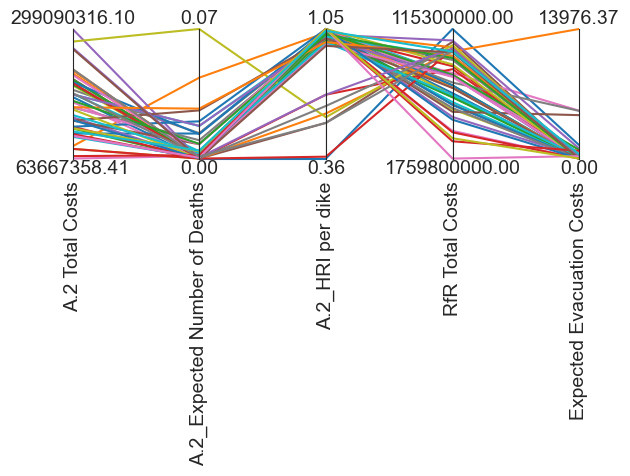

<Figure size 1400x1000 with 0 Axes>

In [103]:
data = results.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis("RfR Total Costs")
    # Set larger figure size (wider and taller)
plt.figure(figsize=(14, 10))  # width=12 inches, height=8 inches


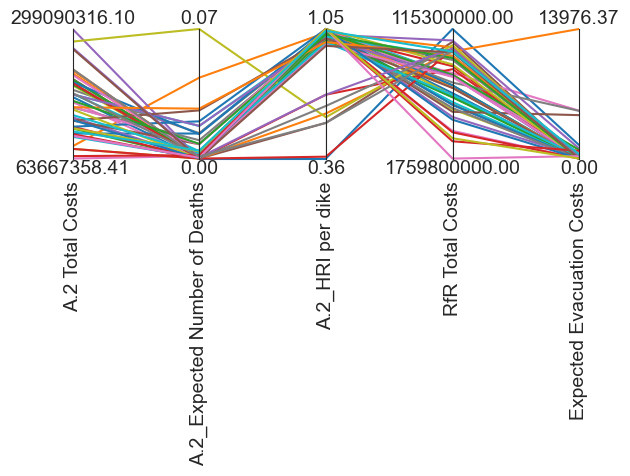

In [104]:

# Generate parallel axes with your limits
paraxes = parcoords.ParallelAxes(limits)

# Plot the data
paraxes.plot(data)

# Invert specific axis
paraxes.invert_axis("RfR Total Costs")

# Save the plot
plt.savefig("mordm_parallel_coordinates.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [105]:
policies = results
policies = policies.drop([o.name for o in model.outcomes], axis=1)
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,1,1,0,0,0,1,1,0,0,0,...,1,7,8,3,9,9,9,7,4,8
1,1,1,1,1,0,1,0,0,0,0,...,2,1,8,6,6,4,1,10,6,3
2,0,1,0,0,0,1,0,0,1,1,...,0,8,1,0,10,8,4,5,10,1
3,0,0,0,0,1,1,1,0,0,1,...,3,8,6,0,8,10,7,10,2,8
4,0,1,1,0,0,0,1,0,1,0,...,5,7,6,8,10,6,9,0,2,3
5,0,0,0,0,0,1,0,1,1,0,...,10,8,5,10,1,10,4,7,7,5
6,0,1,0,0,0,0,1,1,1,1,...,5,6,6,3,0,3,7,10,2,2
7,1,0,1,1,0,0,0,0,0,0,...,3,0,3,3,5,3,6,2,4,7
8,1,1,0,0,1,0,1,1,0,0,...,0,4,0,4,3,8,1,10,1,9
9,1,0,0,0,0,0,0,0,0,1,...,0,5,8,9,10,2,10,4,3,6


## Hier onder worden de policies gemaakt die getest moeten worden

In [106]:

policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [107]:
n_scenarios = 100
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

python(54839) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54843) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54844) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54845) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54846) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54847) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54848) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54849) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 100 scenarios * 50 policies * 1 model(s) = 5000 experiments
100%|██████████████████████████████████████| 5000/5000 [04:13<00:00, 19.75it/s]

In [108]:
results

(      A.0_ID flood wave shape    A.1_Bmax A.1_Brate  A.1_pfail    A.2_Bmax  \
 0                          93  242.555310      10.0   0.122230  310.566086   
 1                           6  321.934832      10.0   0.107091  258.591271   
 2                          13  104.534577       1.0   0.390025  208.509065   
 3                          55  148.721267      10.0   0.203228  124.231269   
 4                          85   57.982386      10.0   0.787225   92.172791   
 ...                       ...         ...       ...        ...         ...   
 4995                       26  147.466223      10.0   0.222010  222.741345   
 4996                       57  133.400900       1.5   0.483406   85.258810   
 4997                       91  342.669347       1.5   0.177664  150.532833   
 4998                       26  127.480884       1.0   0.185003  248.184717   
 4999                      106  348.155248       1.5   0.030163  261.334922   
 
      A.2_Brate  A.2_pfail    A.3_Bmax A.3_Brate  

In [109]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    if std==0:
        std = 1

    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std


In [110]:
from ema_workbench import ScalarOutcome

experiments, outcomes = results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy']==policy

    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.2 Total Costs,A.2_Expected Number of Deaths,A.2_HRI per dike,RfR Total Costs,Expected Evacuation Costs
0,2.216829e+16,5.990311e-03,3.538607e+00,9.299000e+08,0.000000e+00
1,5.927767e+16,3.368865e-02,1.367013e+00,6.894000e+08,0.000000e+00
10,5.062766e+15,2.571798e-06,3.242592e+15,1.153000e+08,1.065372e+08
11,8.651684e+14,4.615017e-08,6.000000e-01,4.004000e+08,3.284640e+07
12,4.416016e+14,1.064683e-08,8.917127e+15,9.835000e+08,3.297726e+06
13,6.431188e+14,6.906221e-07,3.152520e+15,6.258000e+08,6.195183e+06
14,1.925884e+14,5.872642e-09,2.296836e+15,2.613000e+08,1.981927e+06
15,7.112398e+13,2.378811e-10,1.040000e+00,1.072100e+09,4.033512e+06
16,1.275615e+14,6.479683e-08,2.296836e+15,1.408800e+09,0.000000e+00
17,1.463327e+16,4.544917e-05,3.723344e+00,7.950000e+08,1.714888e+07


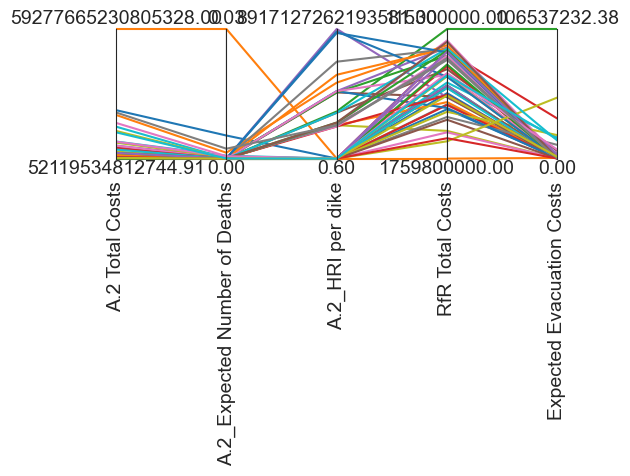

In [111]:
data = scores
limits = parcoords.get_limits(data)


paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis("RfR Total Costs")

plt.show()